#### 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from matplotlib import font_manager, rc
%matplotlib inline
from matplotlib import cm 

# 한글 폰트
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

pd.set_option('max_columns', 100, 'max_rows', 20)

#### 데이터 불러오기

In [2]:
# 추정 매출 
buy_data = pd.read_csv('./Data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_수정본.csv')
buy_data = buy_data.iloc[:,1:]

year_month = []
for i in range(buy_data.shape[0]):
    year_month.append(str(buy_data['기준_년_코드'].iloc[i]) + '-' + str(buy_data['기준_분기_코드'].iloc[i]))

buy_data['년-분기'] = year_month

# 대학 상권 list
college_commercial = pd.read_csv('./Data/대학인근상권.csv')

# 상권 점포 데이터 
store_inf = pd.read_csv('./Data/서울시 우리마을가게 상권분석서비스(상권점포-통합).csv', low_memory=False)

### 해당 상권의 총 점포수 확인(프랜차이즈 점포수까지 확인)
store_inf['총_점포_수'] = store_inf['점포_수'] + store_inf['프랜차이즈_점포_수']

year_month = []
for i in range(store_inf.shape[0]):
    year_month.append(str(store_inf['기준_년_코드'].iloc[i]) + '-' + str(store_inf['기준_분기_코드'].iloc[i]))

store_inf['년-분기'] = year_month

## 0. 데이터 확인하기

> 이상한 데이터 있으면 해결하기

#### 1) 대학 상권 분석하기

In [3]:
print("----- 상권 내용 분석 ----- \n")

college_cm_name = list(college_commercial['TRDAR_CD_N'].unique())
buy_data_cm_data = list(buy_data['상권_코드_명'].unique())

print("추청매출 데이터(서울 상권 분석 서비스)의 상권 개수: {}개".format(len(buy_data_cm_data)))
print("추출한 대학 상권 개수: {}개".format(len(college_cm_name)))
print("대학 상권의 비율: {:.2f}%".format(len(college_cm_name) / len(buy_data_cm_data)))

print("대학 상권에만 있는 상권 list: {} \n".format(list(set(college_cm_name).difference(set(buy_data_cm_data)))))

----- 상권 내용 분석 ----- 

추청매출 데이터(서울 상권 분석 서비스)의 상권 개수: 1480개
추출한 대학 상권 개수: 317개
대학 상권의 비율: 0.21%
대학 상권에만 있는 상권 list: ['숭문8길', '신촌로28가길'] 



#### 2) 추정매출 데이터에서 상권 개수 변화 확인
- 이전 전처리에서 문제가 없었는지 확인

[1] 상권 내에서 오탈자 문제: 종로?청계 관광특구(2020-4분기)

In [4]:
print("---- 각 분기별 등장하는 상권의 개수 확인 ----")

display(buy_data.drop_duplicates(['년-분기','상권_코드_명']).groupby('년-분기')['상권_코드_명'].count())
display(buy_data.drop_duplicates(['년-분기','상권_코드_명']).groupby('년-분기')['상권_코드_명'].count().value_counts())

store_202101 = set(buy_data[buy_data['년-분기'] == "2021-1"].상권_코드_명.unique())
store_202004 = set(buy_data[buy_data['년-분기'] == "2020-4"].상권_코드_명.unique())

print("\n---- 2020-4분기에만 등장하는 상권 확인----")

print("2020-4분기만 등장하는 상권 list: {} \n".format(list(set(store_202101).difference(set(store_202004)))))
print("2020-4분기만 등장하는 상권 list: {} \n".format(list(set(store_202004).difference(set(store_202101)))))

buy_data['상권_코드_명'] = buy_data['상권_코드_명'].agg(lambda x: '종로·청계 관광특구' if x =='종로?청계 관광특구' else x)

---- 각 분기별 등장하는 상권의 개수 확인 ----


년-분기
2016-1    1479
2016-2    1479
2016-3    1479
2016-4    1479
2017-1    1479
          ... 
2020-2    1479
2020-3    1479
2020-4    1479
2021-1    1479
2021-2    1479
Name: 상권_코드_명, Length: 22, dtype: int64

1479    22
Name: 상권_코드_명, dtype: int64


---- 2020-4분기에만 등장하는 상권 확인----
2020-4분기만 등장하는 상권 list: ['종로?청계 관광특구'] 

2020-4분기만 등장하는 상권 list: ['종로·청계 관광특구'] 



#### 3) 개폐율에 대한 데이터 확인
- (위의 내용) 각분기별 상권의 개수 확인: 202-04분기에만 등장한 상권48개는 제거 / 오탈자 고치기
- 추정매출과 같은 전처리 진행(각 상권에서 22개 분기 모두 등장하는 업종만 가져오기)

In [5]:
# 각 분기별로 상권의 개수 (한 분기만 1544로 다름 : 2020-4분기)

print("---- 각 분기별 등장하는 상권의 개수 확인 ----")

display(store_inf.drop_duplicates(['년-분기','상권_코드_명']).groupby('년-분기')['상권_코드_명'].count())
display(store_inf.drop_duplicates(['년-분기','상권_코드_명']).groupby('년-분기')['상권_코드_명'].count().value_counts())

store_202101 = set(store_inf[store_inf['년-분기'] == "2021-1"].상권_코드_명.unique())
store_202004 = set(store_inf[store_inf['년-분기'] == "2020-4"].상권_코드_명.unique())

print("\n---- 2020-4분기에만 등장하는 상권 확인----")

print("2020-4분기만 등장하는 상권 list: {} \n".format(list(set(store_202101).difference(set(store_202004)))))
print("2020-4분기만 등장하는 상권 list: {} \n".format(list(set(store_202004).difference(set(store_202101)))))

---- 각 분기별 등장하는 상권의 개수 확인 ----


년-분기
2016-1    1496
2016-2    1496
2016-3    1496
2016-4    1496
2017-1    1496
          ... 
2020-2    1496
2020-3    1496
2020-4    1544
2021-1    1496
2021-2    1496
Name: 상권_코드_명, Length: 22, dtype: int64

1496    21
1544     1
Name: 상권_코드_명, dtype: int64


---- 2020-4분기에만 등장하는 상권 확인----
2020-4분기만 등장하는 상권 list: ['종로?청계 관광특구'] 

2020-4분기만 등장하는 상권 list: ['정동_중심시가지형', '홍릉 연구단지_경제기반형', '공항동_일반근린형', '난곡난향동_주거지지원형', '경복궁 서측(청운효자사직동)_일반근린형', '장안평_경제기반형', '신월3동_주거지지원형', '불광2동_주거지지원형', '장위동_일반근린형', '해방촌_일반근린형', '상도4동_일반근린형', '용산전자상가_경제기반형', '풍납토성_중심시가지형', '안암동 캠퍼스타운_중심시가지형', '419사거리_중심시가지형', '독산우시장_중심시가지형', '도봉2동_일반근린형', '신촌_일반근린형', '창덕궁앞_중심시가지형', '영등포경인로_경제기반형', '수유1동_주거지지원형', '중화2동_주거지지원형', '암사_일반근린형', '종로·청계 관광특구', '사근동_일반근린형', '천연충현동_일반근린형', '청량리종합시장_중심시가지형', '창신숭인_일반근린형', '사당4동_일반근린형', '면목패션봉제진흥지구_중심시가지형', '응암3동_일반근린형', '서울역_일반근린형', '성내2동_일반근린형', '홍제역_중심시가지형', '효창공원_중심시가지형', '세운상가_중심시가지형', '마장동_중심시가지형', '창동상계_경제기반형', '서울역_경제기반형', '송정동_일반근린형', '목3동_일반근린형', '북촌가회동_중심시가지형', '구로2동_주거지지원형', '구의역_중심시가지형', '가리봉동_일반근린형', '성수_일반근린형', '묵2동_일반근린형', '인수동_일반근린형', '창3동_일반근린형'] 



In [6]:
# 오탈자 변경
store_inf['상권_코드_명'] = store_inf['상권_코드_명'].agg(lambda x: '종로·청계 관광특구' if x =='종로?청계 관광특구' else x)

# 상권 개수 맞춰서 진행하기
store_point_list = list(store_inf[store_inf['년-분기'] == "2016-1"]['상권_코드_명'].unique())
store_inf = store_inf.query('상권_코드_명 in @ store_point_list')

In [7]:
#### 상권별 - 서비스 업종이 22개 등장하는 업종만 뽑기 
find_value = (store_inf.groupby(['상권_코드','서비스_업종_코드_명'])[['기준_년_코드','기준_분기_코드']].count() == 22).reset_index()
find_value = find_value[(find_value['기준_년_코드'] == True)]

# 22분기에 등장하는 상권-서비스 업종 대응 list
commercial_code = []
service_type_code = []
for i in find_value['상권_코드'].unique():
    commercial_code.append(i)
    value_list = []
    find_value_part = find_value[find_value['상권_코드'] == i]
    for j in find_value_part['서비스_업종_코드_명'].unique():
        value_list.append(j)
        value_list = list(set(value_list))
    service_type_code.append(value_list)
    
# 각 상권코드를 가지고 와서 query문으로 데이터 정제
selected_data = []
for num,i in enumerate(commercial_code):  
    price_df_1 = store_inf[store_inf['상권_코드'] == i]
    find_servicetype_list = service_type_code[num]
    
    price_df_2 = price_df_1.query('서비스_업종_코드_명 in @ find_servicetype_list')    
    # 상권코드와 조합되는 서비스 업종 코드명으로 데이터 정제 후 저장
    
    selected_data.append(price_df_2)
    
data_cm = pd.concat(selected_data)
data_cm.to_csv('서울시 우리마을가게 상권분석서비스(상권점포-통합)_수정본(전처리).csv')

store_inf = data_cm
store_inf = store_inf.reset_index(drop = True)

In [8]:
'''store_inf = pd.read_csv('서울시 우리마을가게 상권분석서비스(상권점포-통합)_수정본(전처리).csv')
store_inf = store_inf.reset_indexd(drop = True)'''

"store_inf = pd.read_csv('서울시 우리마을가게 상권분석서비스(상권점포-통합)_수정본(전처리).csv')\nstore_inf = store_inf.reset_indexd(drop = True)"

## 1. 시계열 데이터 Cluster

#### (1) 전처리 - 업종별- 중분류 만들기 

- 음식점류 : '한식음식점','양식음식점','분식전문점','중식음식점','치킨전문점','일식음식점', '패스트푸드점'
- 디저트류: '커피-음료' ,'제과점'
- 소매점류: '슈퍼마켓','편의점',
- 주점류: '호프-간이주점'
- 오락류: '당구장','노래방','PC방'
- 미용뷰티류: '미용실','네일숍','화장품','피부관리실',

In [9]:
print("buy_data에 서비스 업종 종류: \n{}".format(list(buy_data.서비스_업종_코드_명.unique())))

#### 중분류 만들기
food_type = ['한식음식점','양식음식점','분식전문점','패스트푸드점','중식음식점','치킨전문점','일식음식점']
desert_type = ['커피-음료' ,'제과점']
market_type = ['슈퍼마켓','편의점']
drunk_type = ['호프-간이주점'] 
game_type = ['당구장','노래방','PC방','골프연습장']
bueaty_type = ['미용실','네일숍','화장품','피부관리실']

buy_data['서비스_업종_중분류'] = buy_data['서비스_업종_코드_명'].agg(lambda x: '음식점류' if x in food_type else '디저트류' 
                                                     if x in desert_type else '마켓류' if x in market_type else '주점류' 
                                                     if x in drunk_type else '오락류' if x in game_type else '미용뷰티류' 
                                                     if x in bueaty_type else '기타')

# 기타 중분류는 분류에서 제외
data = buy_data[buy_data['서비스_업종_중분류'] != '기타'].reset_index(drop = True)

# 대학상권만 가져오기
machul = data[data['상권_코드_명'].isin(college_cm_name)]
machul = machul.reset_index(drop=True)

buy_data에 서비스 업종 종류: 
['한식음식점', '편의점', '양식음식점', '분식전문점', '미용실', '제과점', '커피-음료', '한의원', '패스트푸드점', '가방', '일반의류', '슈퍼마켓', '중식음식점', '여관', '스포츠클럽', '세탁소', '당구장', '서적', '호프-간이주점', '반찬가게', '컴퓨터및주변장치판매', '시계및귀금속', '전자상거래업', '일식음식점', '치과의원', '치킨전문점', '의약품', '화초', '문구', '화장품', '핸드폰', '예술학원', '네일숍', '가구', '육류판매', '안경', '노래방', '외국어학원', '미곡판매', '자동차수리', '일반의원', '일반교습학원', '피부관리실', '조명용품', '의료기기', '인테리어', '가전제품', 'PC방', '애완동물', '스포츠 강습', '철물점', '청과상', '운동/경기용품', '섬유제품', '자동차미용', '신발', '골프연습장', '자전거 및 기타운송장비', '수산물판매', '가전제품수리', '완구', '부동산중개업', '고시원']


#### (2) 각 상권별 분기 점포수 확인

- 헤당 상권의 평균 점포수가 특정 값(thresholo) 낮으면 해당 상권 제거: 3 기준 

In [189]:
check = machul.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '점포수', aggfunc = 'sum', 
                           fill_value = 0).sort_values(by = '2016-1')
check['평균_점포수'] = check.mean(axis = 1).round(2)

In [190]:
# 점포수가 적어 제거될 상권
except_cm = list(check.query('평균_점포수 <=100').index)
print("점포수가 적어 제거될 상권: {}".format(except_cm))

# 해당 상권 제거
final_data = machul.query('상권_코드_명 != @except_cm').reset_index(drop=True)

print("최종 사용할 상권 수: {}개".format(len(machul['상권_코드_명'].unique())))

점포수가 적어 제거될 상권: ['유영시장', '동호로20길', '새석관시장', '사당로23나길', '석관시장', '창신길', '백련시장', '한아름시장', '삼선교로16가길', '이경시장', '밤나무골시장', '휘경로23길', '사당로23길', '서달로14길', '이문제일시장', '개봉중앙시장', '강남시장_동작', '백운시장', '청파로47나길', '통일로12길', '통일로11길', '서달로10길', '보문로26길', '증가로20가길', '용답중앙길', '장위로50길', '이문로42길', '장충단로8길', '성북로8길', '동호로15길', '정릉로27길', '서울시립대로16길', '돌곶이로8길', '고척로52길', '답십리로23길', '증가로6길', '서초대로64길', '사당로2차길', '서교시장', '청파로73길', '신촌로30길', '고척로27다길', '노해로33길', '신촌로37길', '석관황금시장', '독막로22길', '만리시장', '사당로16가길', '망우로18가길', '창경궁로43길', '서초중앙로8길', '오류시장', '한강대로88길', '삼선교로10다길', '솔샘로6길', '독립문로8길', '돌곶이로14길', '인촌로17가길', '아차산로40길', '제기로21길', '북아현로4길', '필운대로1길', '상도로47길', '옥인길', '개봉로17다길', '공항대로55길', '서달로8가길', '창경궁로35길', '전농로터리시장', '두텁바위로1길', '연서로11길', '화랑로19길', '지봉로8길', '동소문로13길', '인촌로5길', '홍연길', '청림3길', '연서로3길', '송정12라길', '창신2길', '개봉로17길', '독막로32길', '오패산로19길', '서울시립대로29길', '동소문로15길', '용마산로100길', '은평로8길', '등촌로55길', '아현가구거리상점가', '퇴계로46길', '와우산로3길', '지봉로20길', '대림골목시장', '화랑로14길', '상원12길', '화랑로32길', '흑석로13길', '등촌로51길', '사임당로

#### (3) 클러스터

In [191]:
from sklearn.cluster import KMeans
# 상권별 분기 매출금액
df = final_data.groupby(['상권_코드_명', '년-분기'])['분기당_매출_금액'].sum().reset_index()
df = df.rename(columns = {'분기당_매출_금액': '분기당_총매출금액'})

# seed 고정
seed = 0
np.random.seed(seed)

display(df.head())

temp_0 = df.set_index(['년-분기','상권_코드_명'])['분기당_총매출금액'].unstack().transpose()
temp_0 = temp_0.apply(lambda x: ((x - x.mean()) / x.std()), axis=1)

display(temp_0.head(2))

,상권_코드_명,년-분기,분기당_총매출금액
0,강동대로53길,2016-1,8.291062e+09
1,강동대로53길,2016-2,8.670532e+09
2,강동대로53길,2016-3,9.154798e+09
3,강동대로53길,2016-4,1.008225e+10
4,강동대로53길,2017-1,9.507359e+09


년-분기,2016-1,2016-2,2016-3,2016-4,2017-1,2017-2,2017-3,2017-4,2018-1,2018-2,2018-3,2018-4,2019-1,2019-2,2019-3,2019-4,2020-1,2020-2,2020-3,2020-4,2021-1,2021-2
상권_코드_명,,,,,,,,,,,,,,,,,,,,,,
강동대로53길,0.190102,0.383280,0.629807,1.101948,0.809286,1.280551,1.238059,1.082902,0.555507,0.864373,0.566099,1.386409,-0.942815,-1.136050,-0.847726,-0.381322,-1.173327,-0.836046,-1.044959,-1.173545,-1.451456,-1.101077
강서구청,0.799597,0.781914,0.982943,1.038210,0.831829,0.893753,0.900096,1.016342,0.669862,0.519585,0.447916,0.936730,-0.696123,-0.898715,-0.544813,-0.164303,-0.681126,-0.674942,-0.993858,-1.513251,-2.042683,-1.608963


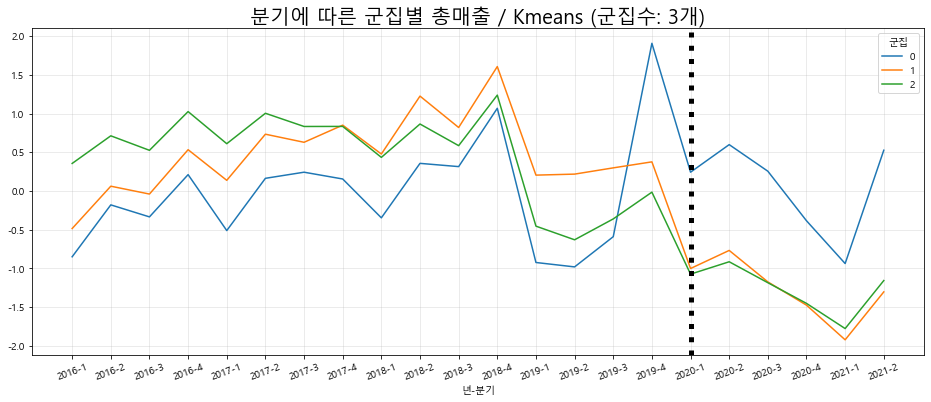

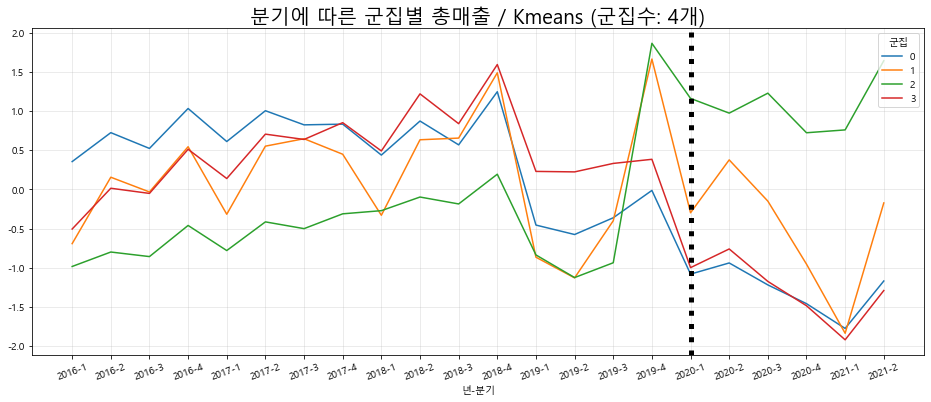

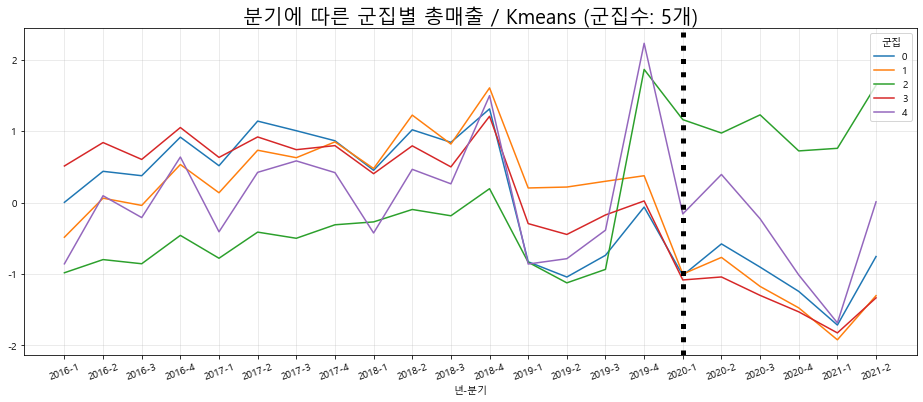

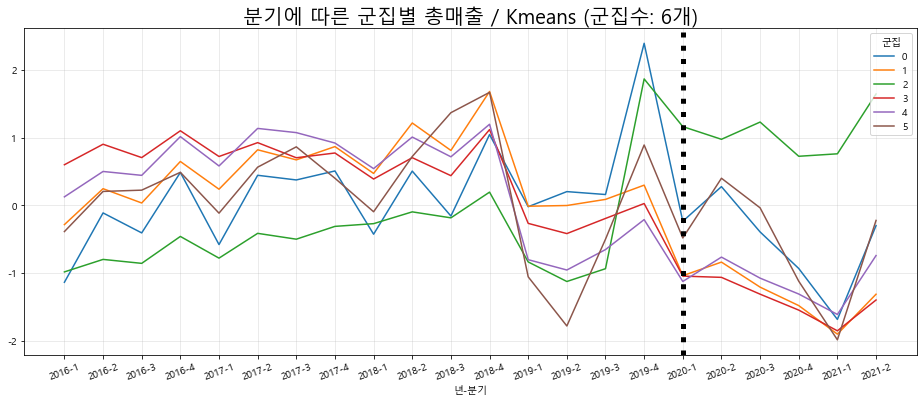

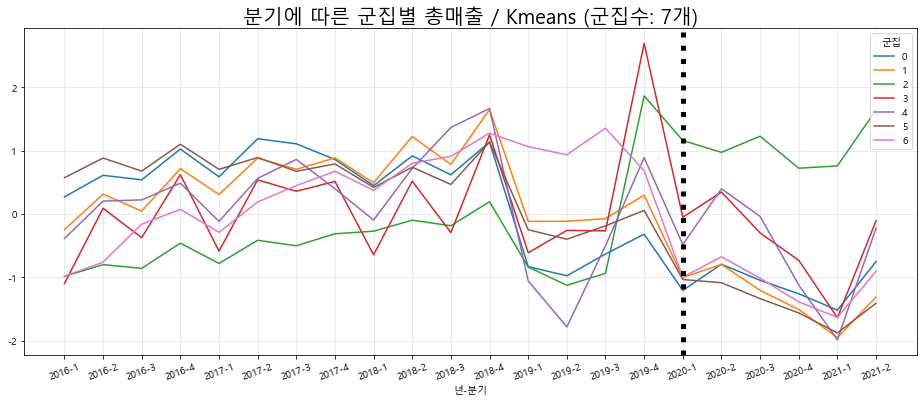

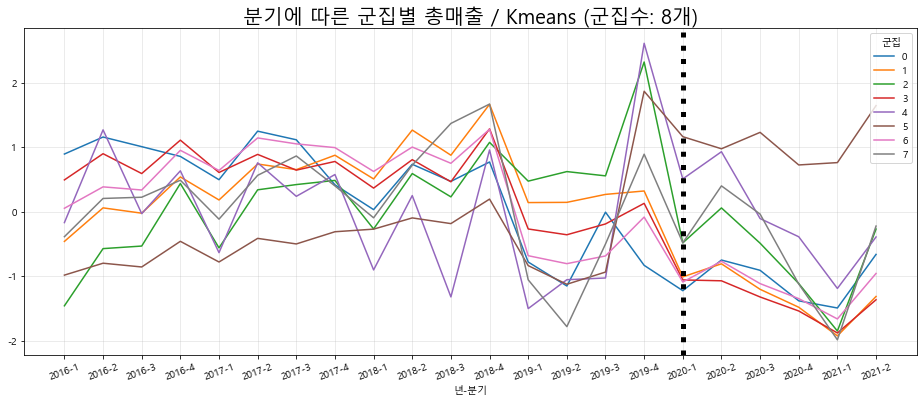

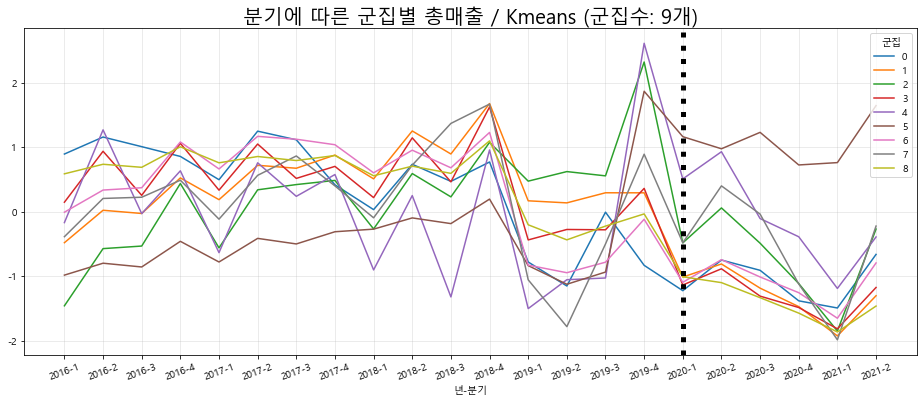

In [192]:
for i in range(3, 10):
    temp_final = temp_0.copy()
    kmeans = KMeans(n_clusters=i, random_state=0).fit(temp_final)
    temp_final['segment'] = kmeans.labels_
    ax = temp_final.groupby('segment').mean().T.plot(figsize=(16,6))
    plt.xticks([i for i in range(len(temp_final.columns)-1)], temp_final.columns[:-1], rotation=20)
    plt.legend(loc='upper right', title='군집')
    plt.axvline(x = 16, color = 'black', linestyle = ':',linewidth=5)
    plt.grid(alpha=0.3)
    plt.title('분기에 따른 군집별 총매출 / Kmeans (군집수: {}개)'.format(i) ,size=20)
    plt.show()

#### 클러스터 결과 정리: 위의 그래프 중 군집 수 결정: 6개

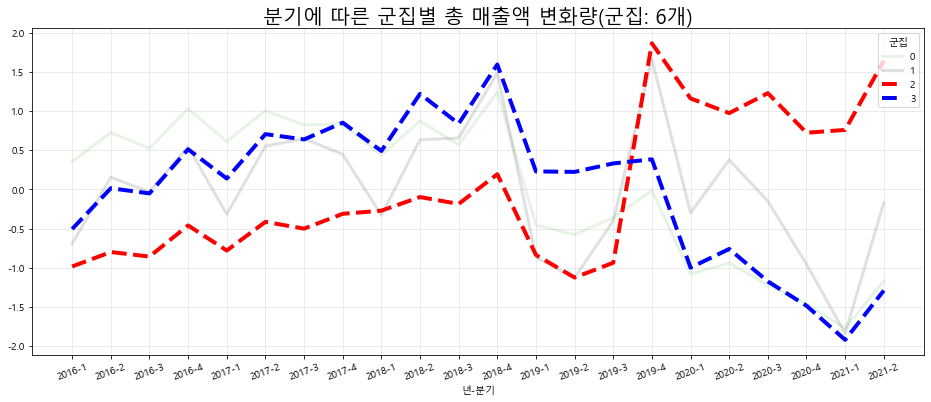

In [196]:
temp_final = temp_0.copy()

# cluster
kmeans = KMeans(n_clusters=4, random_state=0).fit(temp_final)
temp_final['segment'] = kmeans.labels_

ax=temp_final.query('segment != 2 and segment !=3').groupby('segment').mean().T.plot(figsize=(16, 6), 
                                                                  cmap=plt.cm.Accent, linewidth=3, style='-', alpha=0.2)
ax=temp_final.query('segment == 2').groupby('segment').mean().T.plot(ax=ax, color='Red', linewidth=4, style='--', alpha=1)
ax=temp_final.query('segment == 3').groupby('segment').mean().T.plot(ax=ax, color='blue', linewidth=4, style='--', alpha=1)

plt.xticks([i for i in range(len(temp_final.columns)-1)], temp_final.columns[:-1], rotation=20)

plt.legend(loc='upper right', title='군집')
plt.grid(alpha=0.3)
plt.title('분기에 따른 군집별 총 매출액 변화량(군집: 6개)', size=20)
plt.show()

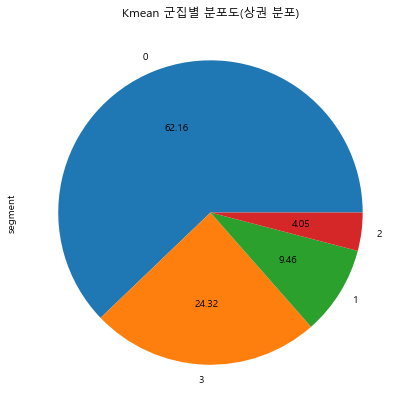

0    46
3    18
1     7
2     3
Name: segment, dtype: int64

In [197]:
temp_final['segment'].value_counts().plot(kind='pie', title = "Kmean 군집별 분포도(상권 분포)",figsize = (14,7),autopct='%.2f')
plt.show()

display(temp_final['segment'].value_counts())

In [198]:
#### cluster 결과 빼기
cluster_result = temp_final.reset_index()[['상권_코드_명','segment']]
cluster_result.head()

년-분기,상권_코드_명,segment
0,강동대로53길,0
1,강서구청,0
2,개봉동 현대아파트 인근,1
3,개봉로23가길,3
4,개운사길,3


## 2. 개폐율에 따른 사분할 scatter plot

- 상권 점포도 추정매출 간의 군집화 했던 부분들과 동일하게 맞춰주기 위해 전처리 진행
        (1) 중분류 中 기타 제외
        (2) 점포수가 적은 
        
        
#### (1) 전처리

In [199]:
# 각 상권마다 중분류에서 기타를 제외한 부분을 추출
store_inf['서비스_업종_중분류'] =  store_inf['서비스_업종_코드_명'].agg(lambda x: '음식점류' if x in food_type else '디저트류' 
                                                     if x in desert_type else '마켓류' if x in market_type else '주점류' 
                                                     if x in drunk_type else '오락류' if x in game_type else '미용뷰티류' 
                                                     if x in bueaty_type else '기타')
reduce_store_inf = store_inf[store_inf['서비스_업종_중분류'] != '기타'].reset_index(drop = True)

# 상권점포-통합 데이터의 대학상권 추출
college_store_inf = reduce_store_inf .query('상권_코드_명 in @ college_cm_name')

# 추정매출간 점포수가 적었던 상권 제외 
college_store_inf = college_store_inf.query('상권_코드_명 != @except_cm').reset_index(drop=True)

In [200]:
store_inf.서비스_업종_중분류.unique()

array(['기타', '주점류', '음식점류', '디저트류', '미용뷰티류', '오락류', '마켓류'], dtype=object)

#### (2) 데이터 확인

- 첫번째 대학상권 평균 개/폐업률

In [201]:

# 대학상권 분기별 개/폐업률 확인
college_store_cnt = college_store_inf.groupby('년-분기')['총_점포_수'].sum()         # 분기별 대학상권 점포수
college_openstore_cnt = college_store_inf.groupby('년-분기')['개업_점포_수'].sum()  # 분기별 대학상권 개업 점포 수
college_closestore_cnt = college_store_inf.groupby('년-분기')['폐업_점포_수'].sum() # 분기별 대학상권 폐업 점포 수

openstore_ratio_byquan = college_openstore_cnt / college_store_cnt * 100   # 분기별 대학상권 개업률
closestore_ratio_byquan = college_closestore_cnt / college_store_cnt  * 100 # 분기별 대학상권 폐업률

## 코로나 후 이후 비교를 위해 (2020-2분기 이후) 평균을 구함
open_point_aftercovid = np.round(openstore_ratio_byquan.iloc[-6:].mean(), 3)  
close_point_aftercovid = np.round(closestore_ratio_byquan.iloc[-6:].mean(), 3)

display('대학상권(주요 업종)의 (코로나 이후) 평균 개업률 : {}'.format(open_point_aftercovid))
display('대학상권(주요 업종)의 (코로나 이후) 평균 폐업률 : {}'.format(close_point_aftercovid))

'대학상권(주요 업종)의 (코로나 이후) 평균 개업률 : 2.916'

'대학상권(주요 업종)의 (코로나 이후) 평균 폐업률 : 3.432'

- 두번째 대학상권 평균 개/폐업률

In [202]:
store_cnt = reduce_store_inf.groupby('년-분기')['총_점포_수'].sum()        # 분기별 서울상권 점포수
openstore_cnt = reduce_store_inf.groupby('년-분기')['개업_점포_수'].sum()  # 분기별 서울상권 개업 점포 수
closestore_cnt = reduce_store_inf.groupby('년-분기')['폐업_점포_수'].sum() # 분기별 서울상권 폐업 점포 수

openstore_ratio_byquan_seoul = openstore_cnt / store_cnt * 100   # 분기별 서울상권 개업률
closestore_ratio_byquan_seoul = closestore_cnt / store_cnt * 100 # 분기별 서울상권 폐업률

## 코로나 후 이후 비교를 위해 (2020-2분기 이후) 평균을 구함
open_point_aftercovid_seoul = np.round(openstore_ratio_byquan_seoul.iloc[-6:].mean(), 3)  
close_point_aftercovid_seoul = np.round(closestore_ratio_byquan_seoul.iloc[-6:].mean(), 3)

display('서울상권의 (코로나 이후) 평균 개업률 : {}'.format(open_point_aftercovid_seoul))
display('서울상권의 (코로나 이후) 평균 폐업률 : {}'.format(close_point_aftercovid_seoul))

'서울상권의 (코로나 이후) 평균 개업률 : 3.368'

'서울상권의 (코로나 이후) 평균 폐업률 : 3.409'

#### (3) 간단한 EDA

- 대학상권의 폐업 같은 경우는 계절성을 지님 [1분기 증가 > 2분기 하락 > 3분기 증가 > 4분기 하락]
- 대학 상권의 점포 수는 18년부터 점차 하락함(2020-1분기에 갑자기 급등하지만 다시 감소 추세)
- 개업률/폐업률도 사실상 비슷한 추세

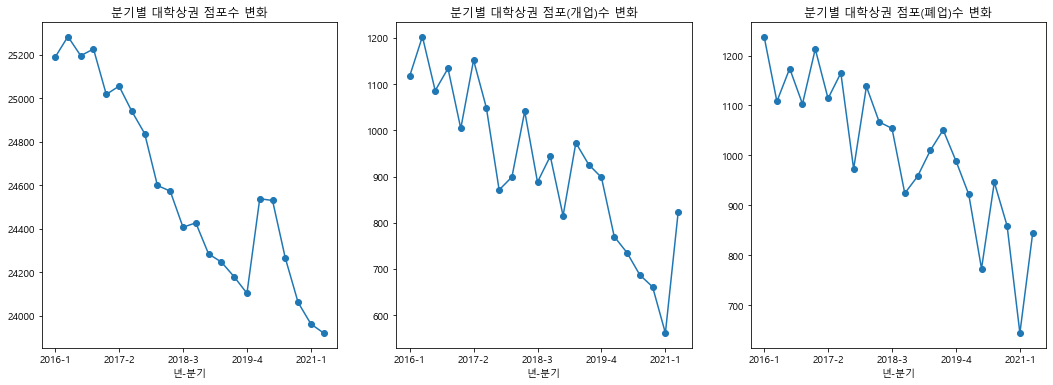

In [203]:
fig, ax = plt.subplots(1, 3, figsize = (18,6))

college_store_cnt.plot(ax = ax[0], title = '분기별 대학상권 점포수 변화', marker ='o')
college_openstore_cnt.plot(ax = ax[1], title = '분기별 대학상권 점포(개업)수 변화', marker ='o')
college_closestore_cnt.plot(ax = ax[2], title = '분기별 대학상권 점포(폐업)수 변화', marker ='o')
plt.show()

In [204]:
#### 상권별 개/폐업률 계산 (점포수, 개업한 점포수 / 페업한 점포 수)

store_cnt_bycma = college_store_inf.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '총_점포_수', \
                                                aggfunc = 'sum',fill_value = 0)

openstore_cnt_bycma = college_store_inf.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '개업_점포_수', 
                                                    aggfunc = 'sum',fill_value = 0)

closestore_cnt_bycma = college_store_inf.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '폐업_점포_수', \
                                                     aggfunc = 'sum',fill_value = 0)

openstore_ratio_bycma = openstore_cnt_bycma.div(store_cnt_bycma) * 100
closestore_ratio_bycma = closestore_cnt_bycma.div(store_cnt_bycma) * 100

#### 상권별 코로나 이후 평균 개/폐업률
openratio_bycma_aftercovid = np.round(openstore_ratio_bycma.iloc[:, -6:].mean(axis = 1),3)
closeratio_bycma_aftercovid = np.round(closestore_ratio_bycma.iloc[:, -6:].mean(axis = 1),3)

display('대학 상권별 코로니 이후 평균 개업률')
display(openratio_bycma_aftercovid)

display('대학 상권별 코로니 이후 평균 폐업률')
display(closeratio_bycma_aftercovid)

'대학 상권별 코로니 이후 평균 개업률'

상권_코드_명
강동대로53길         3.577
강서구청            4.294
개봉동 현대아파트 인근    2.879
개봉로23가길         1.584
개운사길            2.517
                ...  
홍익대학교 주변        3.979
화곡로64길          3.650
휘경로2길           2.251
흑석로9길           1.950
흑석시장            2.767
Length: 76, dtype: float64

'대학 상권별 코로니 이후 평균 폐업률'

상권_코드_명
강동대로53길         4.038
강서구청            4.714
개봉동 현대아파트 인근    2.508
개봉로23가길         2.358
개운사길            3.552
                ...  
홍익대학교 주변        4.770
화곡로64길          2.732
휘경로2길           2.969
흑석로9길           3.610
흑석시장            3.283
Length: 76, dtype: float64

#### (4) 사분할 표현
- 전반적인 분포 확인

,개업률(%),폐업률(%),segment,골목상권_유형
상권_코드_명,,,,
강동대로53길,0.661,0.606,0,순환형
강서구청,1.378,1.282,0,순환형
개봉동 현대아파트 인근,-0.037,-0.924,1,정체형
개봉로23가길,-1.332,-1.074,3,정체형
개운사길,-0.399,0.120,3,쇠퇴형


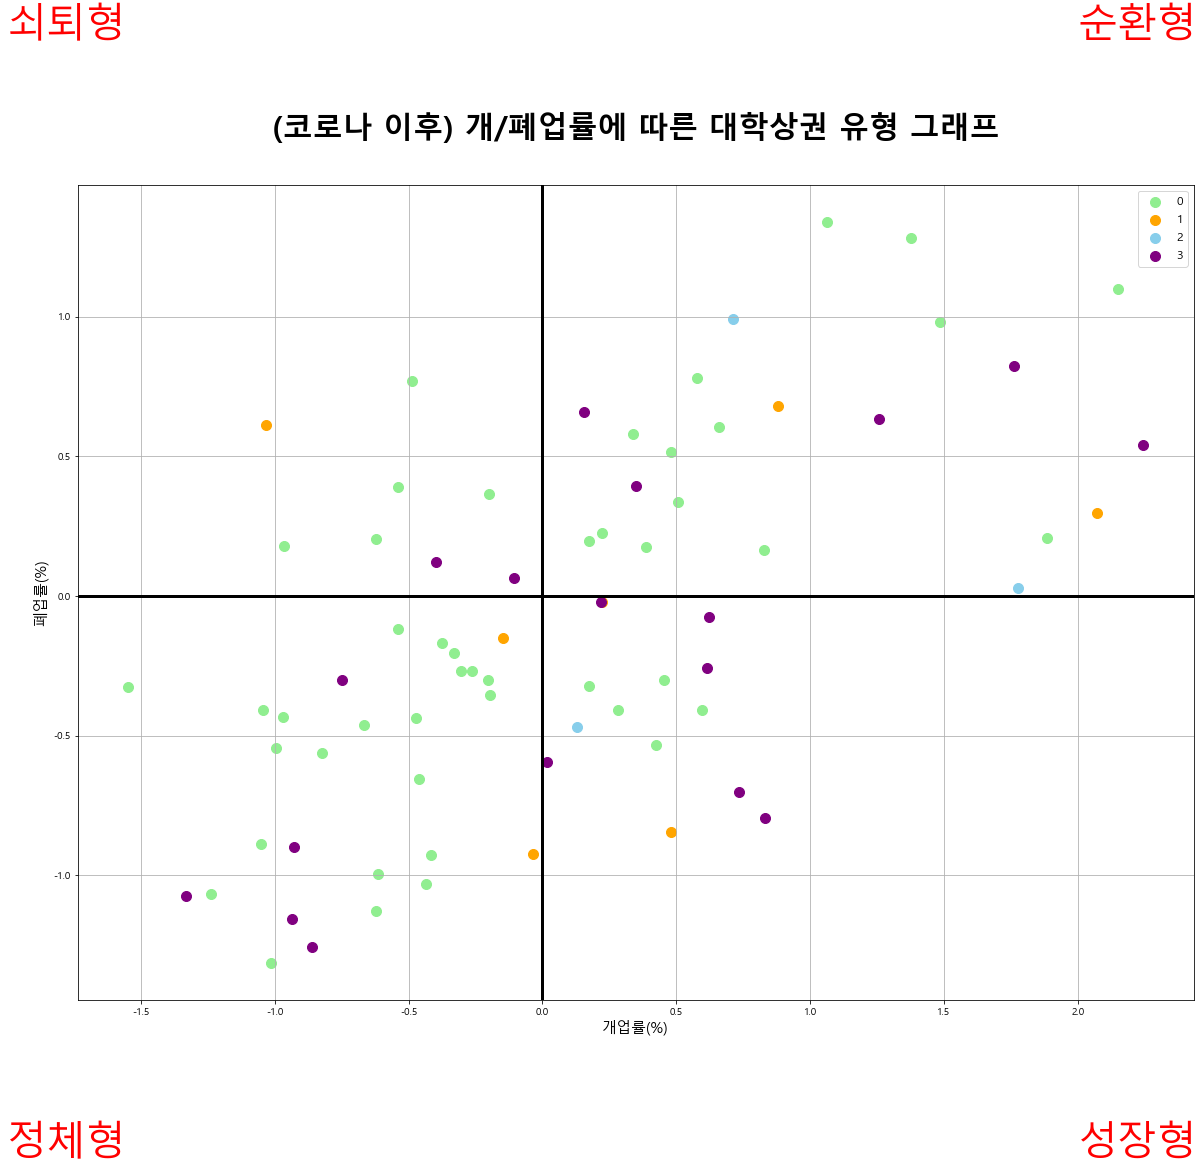

In [206]:
#### 상권별 개/폐업률(코로나 이후) - 상권의 평균 개/페업률(코로나 이후)
open_ratio = openratio_bycma_aftercovid - open_point_aftercovid
close_ratio = closeratio_bycma_aftercovid - close_point_aftercovid

value = pd.DataFrame({'개업률(%)' : open_ratio , '폐업률(%)' : close_ratio})

### segmentation 결과 합치기
value = pd.merge(value.reset_index(), cluster_result, on = '상권_코드_명', how ='inner')
value = value.set_index('상권_코드_명')

# 각 대학 상권별 골목상권 정의
type_of_cm = []

for i in range(value.shape[0]):
    if value.iloc[i, 0] >= 0 and value.iloc[i,1] >= 0:
        type_of_cm.append("순환형")
        
    elif value.iloc[i, 0] >= 0 and value.iloc[i,1] < 0:
        type_of_cm.append("성장형")
        
    elif value.iloc[i, 0] < 0 and value.iloc[i,1] >= 0:
        type_of_cm.append("쇠퇴형")
        
    else:
        type_of_cm.append("정체형")
        
value['골목상권_유형'] = type_of_cm 

display(value.head())


# scatter plot 그리기 
fig, ax = plt.subplots(figsize =(20,15))

groups = value.groupby('segment')
color = ['lightgreen','orange','skyblue','purple','grey','black']

for name, group in groups:
    ax.scatter(group["개업률(%)"], group["폐업률(%)"], marker = 'o', s = 100, label = name, c = color[name])

ax.set_title("(코로나 이후) 개/폐업률에 따른 대학상권 유형 그래프", 
             fontdict= {'fontsize': 30, 'fontweight':'bold'} , y=1.05)
ax.set_xlabel("개업률(%)", fontsize=15)
ax.set_ylabel("폐업률(%)", fontsize=15)
ax.grid()

# x,y축 그리기
plt.axvline(x = 0, color='black', linewidth=3)
plt.axhline(y = 0, color='black', linewidth=3)
ax.legend(fontsize=12, loc='upper right')

# 사분면 정의 된거 text 표시
plt.text(2.0, 2.0, '순환형', fontsize=40, color='red')
plt.text(2.0, -2.0, '성장형', fontsize=40, color='red') 
plt.text(-2.0, -2.0, '정체형', fontsize=40, color='red') 
plt.text(-2.0, 2.0, '쇠퇴형', fontsize=40, color='red') 

plt.show()

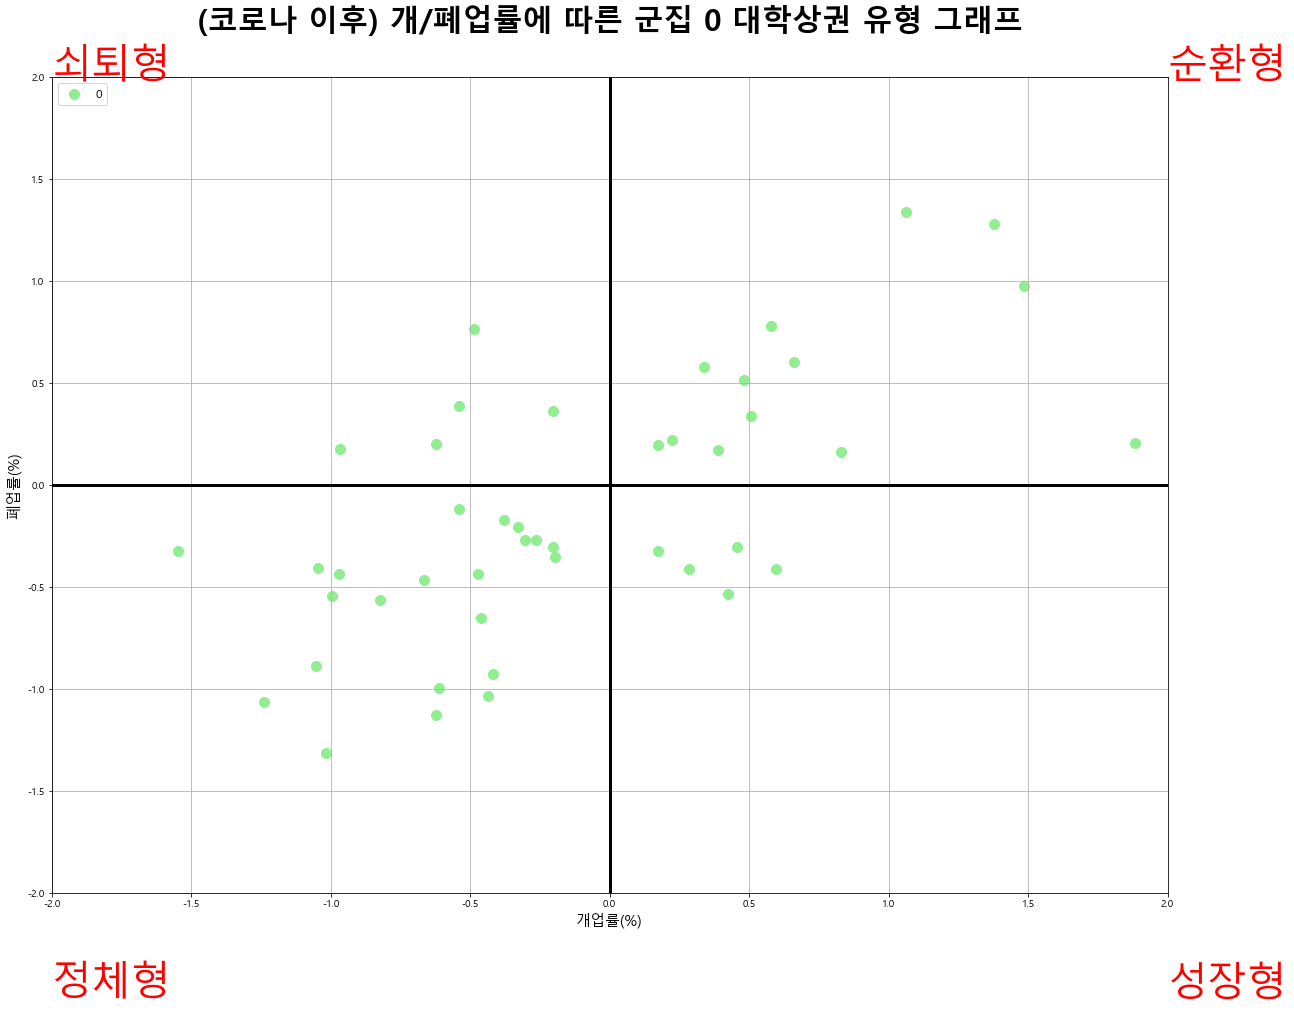

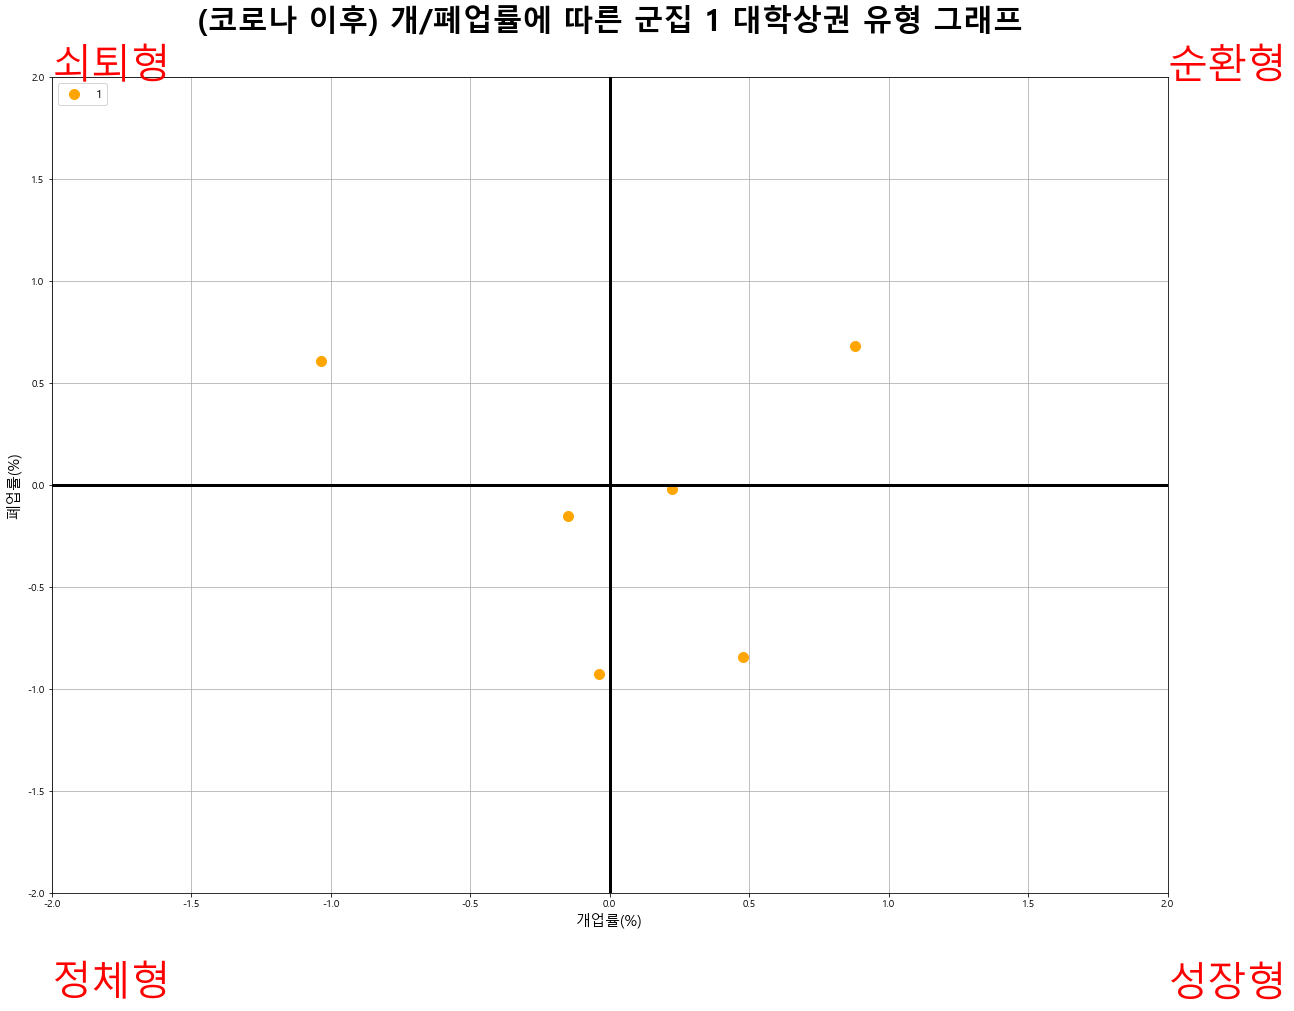

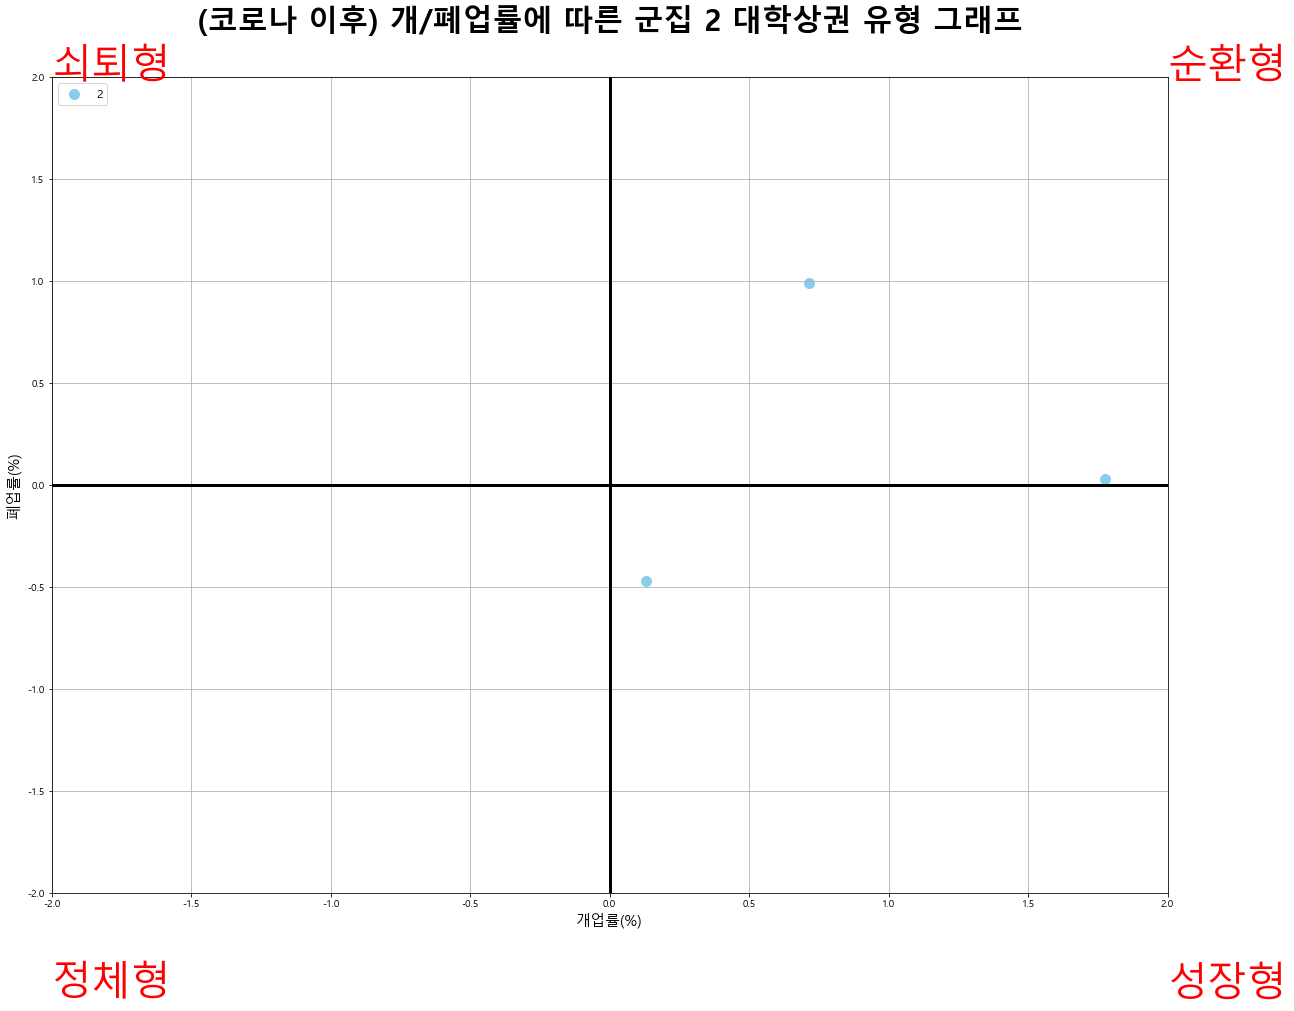

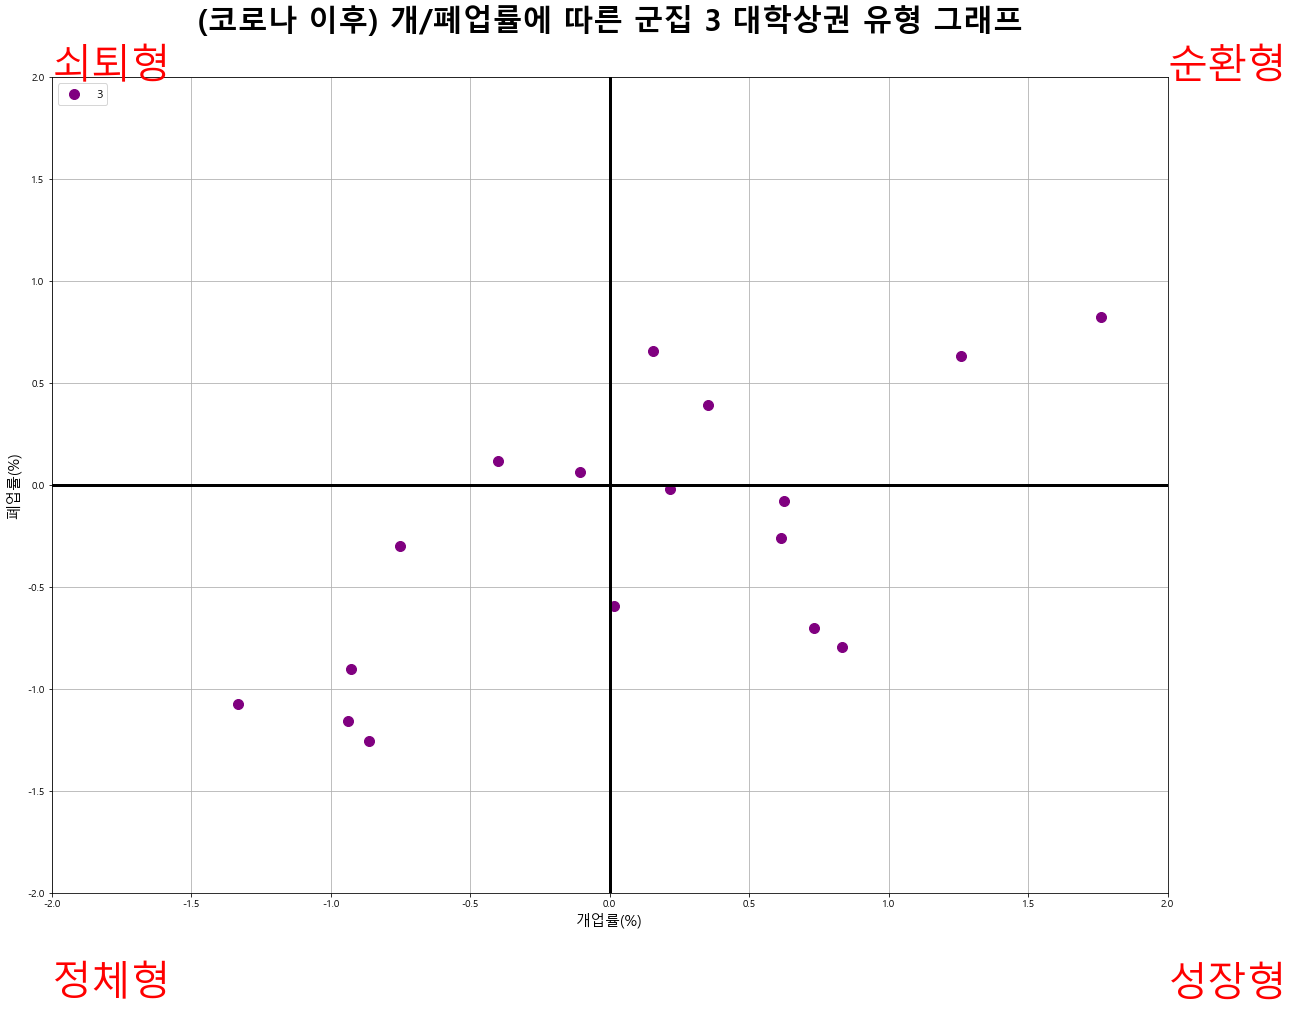

In [208]:
color = ['lightgreen','orange','skyblue','purple','grey','black']

for i, (name, group) in enumerate(groups):
    fig, ax = plt.subplots(figsize =(20,15))
    
    ax.scatter(group["개업률(%)"], group["폐업률(%)"], cmap='coolwarm', s = 100, label = name, c= color[i])

    ax.set_title("(코로나 이후) 개/폐업률에 따른 군집 {} 대학상권 유형 그래프".format(name), 
                 fontdict= {'fontsize': 30, 'fontweight':'bold'} , y=1.05)
    ax.set_xlabel("개업률(%)", fontsize=15)
    ax.set_ylabel("폐업률(%)", fontsize=15)
    ax.grid()
    
    # X,Y 축 고정
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    
    # x,y축 그리기
    plt.axvline(x = 0, color='black', linewidth=3)
    plt.axhline(y = 0, color='black', linewidth=3)
    ax.legend(fontsize=12, loc='upper left')

    # 사분면 정의 된거 text 표시
    plt.text(2.0, 2.0, '순환형', fontsize=40, color='red')
    plt.text(2.0, -2.5, '성장형', fontsize=40, color='red') 
    plt.text(-2.0, -2.5, '정체형', fontsize=40, color='red') 
    plt.text(-2.0, 2.0, '쇠퇴형', fontsize=40, color='red') 


plt.show()

- 눈에 띄는 값들 무엇인지 확인



In [209]:
print("쇠퇴형 中 눈에 띄는 상권 2개:")
display(value.sort_values(by = '폐업률(%)').tail(2))


print("\n\n성장형 中 눈에 띄는 상권 3개:")
display(value.sort_values(by = '개업률(%)').tail(3))

쇠퇴형 中 눈에 띄는 상권 2개:


,개업률(%),폐업률(%),segment,골목상권_유형
상권_코드_명,,,,
강서구청,1.378,1.282,0,순환형
홍익대학교 주변,1.063,1.338,0,순환형




성장형 中 눈에 띄는 상권 3개:


,개업률(%),폐업률(%),segment,골목상권_유형
상권_코드_명,,,,
어린이대공원역,2.072,0.297,1,순환형
백범로16길,2.150,1.100,0,순환형
신촌로12길,2.244,0.539,3,순환형


#### (5) 참고자료 
- 뒤의 기준점을 대학상권 평균 개/폐율이 아니라 서울시로 확장하면/

In [210]:
def open_close_ratio(point, cluster_data):
    
    reduce_store_inf = store_inf[store_inf['서비스_업종_중분류'] != '기타'].reset_index(drop = True)
    
    store_cm_name = list(reduce_store_inf['상권_코드_명'].unique())
    college_store_inf = reduce_store_inf.query('상권_코드_명 in @ college_cm_name')
    
    # 기준이 되는 데이터 선택(대학상권 vs 서울시 vs 클러스터 상권)
    try: 
        if point == "대학상권":
            data = college_store_inf
            
        elif point == "서울시":
            data = reduce_store_inf
            
        elif point == "군집":
            data = cluster_data
        
        # (대학상권 or 서울 상권)의 분기별 개/폐율 구하기
        store_cnt = data.groupby('년-분기')['총_점포_수'].sum()           
        openstore_cnt = data.groupby('년-분기')['개업_점포_수'].sum()  
        closestore_cnt = data.groupby('년-분기')['폐업_점포_수'].sum() 

        openstore_ratio_byquan = openstore_cnt / store_cnt * 100   # 분기별 개업률
        closestore_ratio_byquan = closestore_cnt / store_cnt * 100 # 분기별 폐업률

        # 기준 - 상권의 평균 개/폐율(코로나 이후 판단: 2020-2분기 이후)
        open_point_aftercovid = np.round(openstore_ratio_byquan.iloc[-6:].mean(), 3)  
        close_point_aftercovid = np.round(closestore_ratio_byquan.iloc[-6:].mean(), 3)


        # 대학 상권(개별 상권마다)의 분기별 개/페율 구하기
        store_cnt_bycma = college_store_inf.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '총_점포_수', \
                                                    aggfunc = 'sum',fill_value = 0)

        openstore_cnt_bycma = college_store_inf.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '개업_점포_수', 
                                                            aggfunc = 'sum',fill_value = 0)

        closestore_cnt_bycma = college_store_inf.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '폐업_점포_수', \
                                                             aggfunc = 'sum',fill_value = 0)

        openstore_ratio_bycma = openstore_cnt_bycma.div(store_cnt_bycma) * 100   # 상권별-분기별 개업률
        closestore_ratio_bycma = closestore_cnt_bycma.div(store_cnt_bycma) * 100 # 상권별-분기별 폐업률


        #### 상권별 코로나 이후 평균 개/폐업률
        openratio_bycma_aftercovid = np.round(openstore_ratio_bycma.iloc[:, -6:].mean(axis = 1),3)
        closeratio_bycma_aftercovid = np.round(closestore_ratio_bycma.iloc[:, -6:].mean(axis = 1),3)


        #### 상권별 개/폐업률(코로나 이후) - 상권의 평균 개/페업률(코로나 이후)
        open_ratio = openratio_bycma_aftercovid - open_point_aftercovid
        close_ratio = closeratio_bycma_aftercovid - close_point_aftercovid

        #### DataFrame화
        value = pd.DataFrame({'개업률(%)' : open_ratio , '폐업률(%)' : close_ratio})
        value = pd.merge(value.reset_index(), cluster_result, on = '상권_코드_명', how ='inner')
        value = value.set_index('상권_코드_명')
        
        #### 시각화
        fig, ax = plt.subplots(figsize =(20,15))

        ax.scatter(value["개업률(%)"], value["폐업률(%)"], cmap='coolwarm', s = 100)

        ax.set_title("(코로나 이후) 개/폐업률에 따른 서울 대학상권 유형 그래프", 
                     fontdict= {'fontsize': 30, 'fontweight':'bold'} , y=1.05)
        ax.set_xlabel("개업률(%)", fontsize=15)
        ax.set_ylabel("폐업률(%)", fontsize=15)
        ax.grid()

            # x,y축 그리기
        plt.axvline(x = 0, color='black', linewidth=3)
        plt.axhline(y = 0, color='black', linewidth=3)

            # 사분면 정의 된거 text 표시
        plt.text(5.0, 8.0, '순환형', fontsize=40, color='red')
        plt.text(5.0, -3.5, '성장형', fontsize=40, color='red') 
        plt.text(-2.0, -3.5, '정체형', fontsize=40, color='red') 
        plt.text(-2.0, 8.0, '쇠퇴형', fontsize=40, color='red') 

        plt.show()
        
        
        # 각 대학 상권별 골목상권 정의
        type_of_cm = []

        for i in range(value.shape[0]):
            if value.iloc[i, 0] >= 0 and value.iloc[i,1] >= 0:
                type_of_cm.append("순환형")

            elif value.iloc[i, 0] >= 0 and value.iloc[i,1] < 0:
                type_of_cm.append("성장형")

            elif value.iloc[i, 0] < 0 and value.iloc[i,1] >= 0:
                type_of_cm.append("쇠퇴형")

            else:
                type_of_cm.append("정체형")

        value['골목상권_유형'] = type_of_cm 
        
        return value
    except:
        print("기준이 되는 상권을 3개(대학상권 / 서울시 / 군집) 중 하나를 입력하시오.")

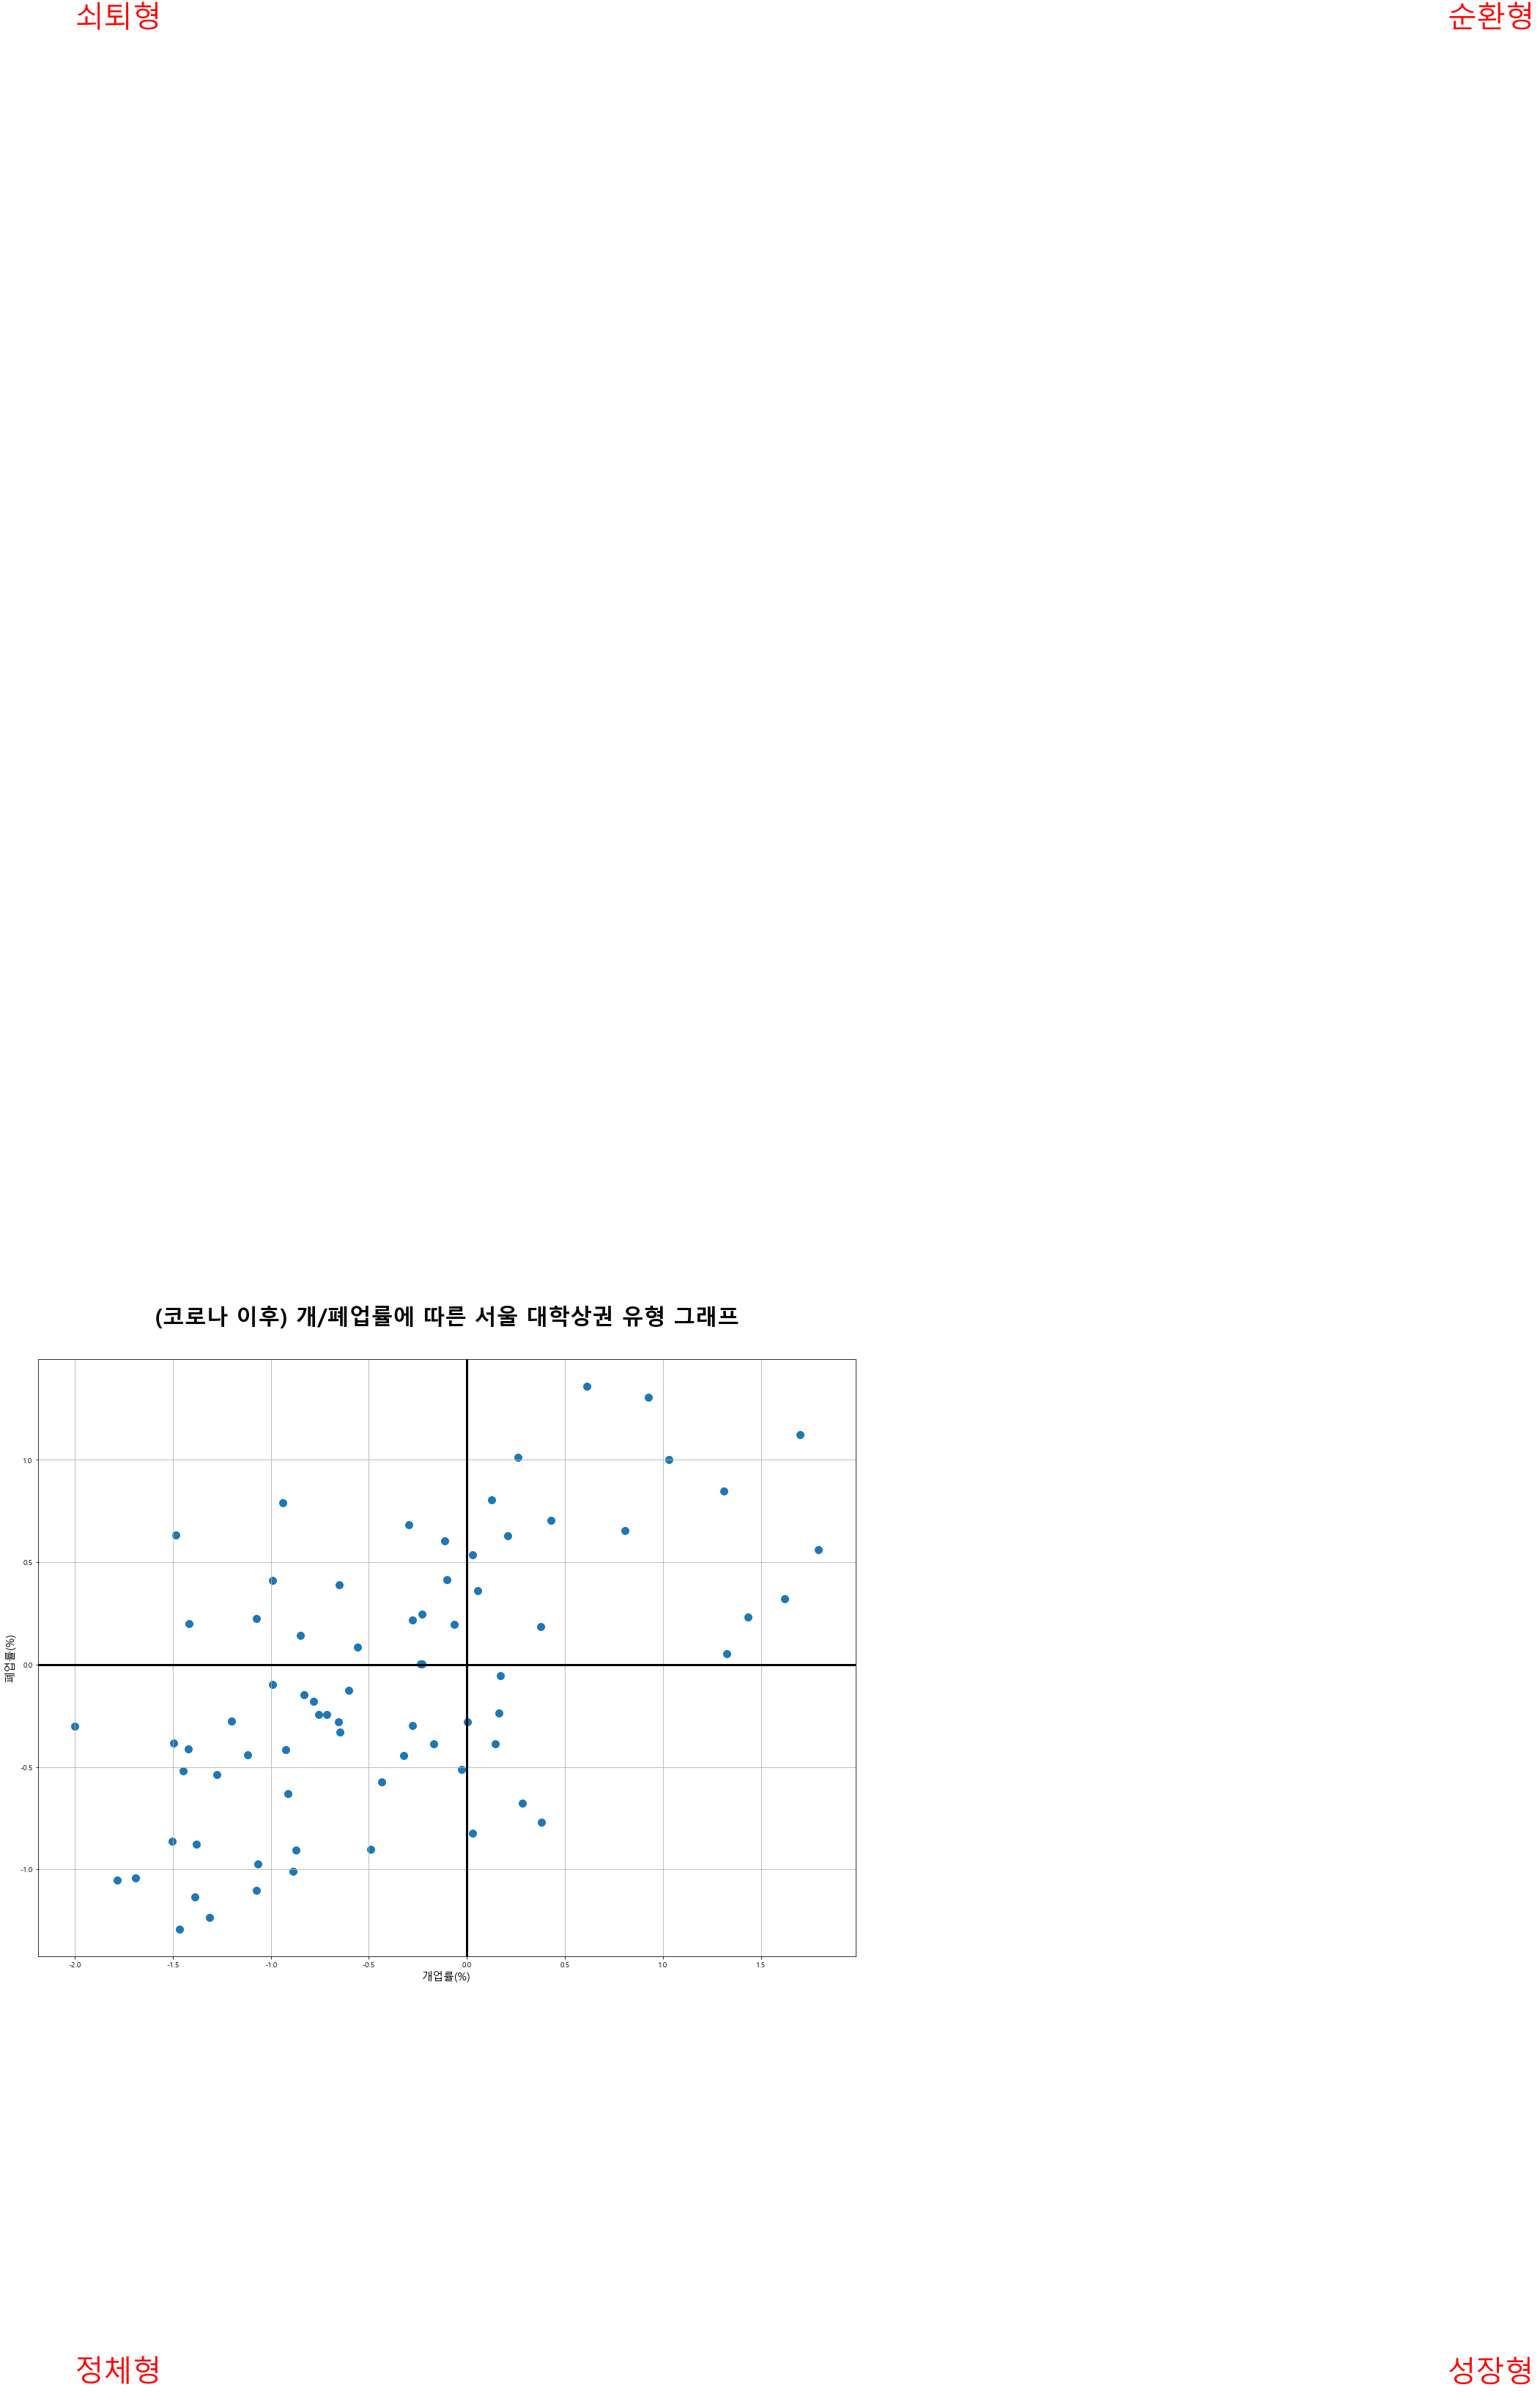

In [211]:
a = open_close_ratio("서울시", None)

대학 상권 기준 point로 잡을 경우: 

정체형    29
순환형    23
성장형    14
쇠퇴형     8
Name: 골목상권_유형, dtype: int64
\서울 기준 point로 잡을 경우: 

정체형    34
순환형    17
쇠퇴형    16
성장형     7
Name: 골목상권_유형, dtype: int64


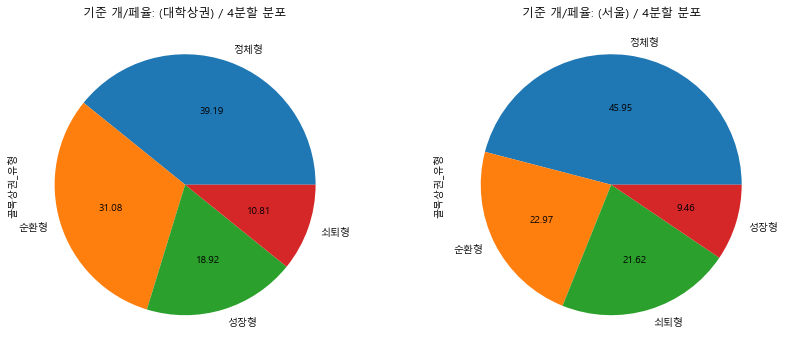

In [212]:
print("대학 상권 기준 point로 잡을 경우: \n")
print(value.골목상권_유형.value_counts())

print("\서울 기준 point로 잡을 경우: \n")
print(a.골목상권_유형.value_counts())

fig, ax = plt.subplots(1,2, figsize = (14,6))

value.골목상권_유형.value_counts().plot(kind='pie', title = "기준 개/페율: (대학상권) / 4분할 분포", autopct='%.2f', ax = ax[0])
a.골목상권_유형.value_counts().plot(kind='pie', title = "기준 개/페율: (서울) / 4분할 분포", autopct='%.2f', ax = ax[1])
plt.show()

### 4. 각 군집별 특성 확인

#### (1) 2번 군집 확인

In [213]:
### 2019년 대학 상권별 개/폐율
openratio_bycma_2019 =  openstore_ratio_bycma.loc[:, ['2019-1','2019-2','2019-3','2019-4']].mean(axis = 1).round(3)
closeratio_bycma_2019 =  closestore_ratio_bycma.loc[:, ['2019-1','2019-2','2019-3','2019-4']].mean(axis = 1).round(3)

### 2019년 대학 상권 평균 개.폐율
open_point_2019 = np.round(openstore_ratio_byquan.iloc[-10:-6].mean(), 3)  
close_point_2019 = np.round(closestore_ratio_byquan.iloc[-10:-6].mean(), 3)

In [214]:
open_2019 = openratio_bycma_2019  - open_point_2019
close_2019 = closeratio_bycma_2019  - close_point_2019

value_2019 = pd.DataFrame({'2019_개업률(%)' : open_2019 , '2019_폐업률(%)' : close_2019})

### segmentation 결과 합치기
value_2019 = pd.merge(value_2019.reset_index(), cluster_result, on = '상권_코드_명', how ='inner')
value_2019 = value_2019.set_index('상권_코드_명')

type_of_2019 = []

for i in range(value_2019.shape[0]):
    if value_2019.iloc[i, 0] >= 0 and value_2019.iloc[i,1] >= 0:
        type_of_2019.append("순환형")

    elif value_2019.iloc[i, 0] >= 0 and value_2019.iloc[i,1] < 0:
        type_of_2019.append("성장형")

    elif value_2019.iloc[i, 0] < 0 and value_2019.iloc[i,1] >= 0:
        type_of_2019.append("쇠퇴형")

    else:
        type_of_2019.append("정체형")

value_2019['2019_골목상권_유형'] = type_of_2019
value_2019 = value_2019.rename(columns = {'segment' : '2019_segment'})

In [215]:
e = pd.merge(value_2019.reset_index(), value.reset_index(), on ='상권_코드_명').query('segment == 2')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


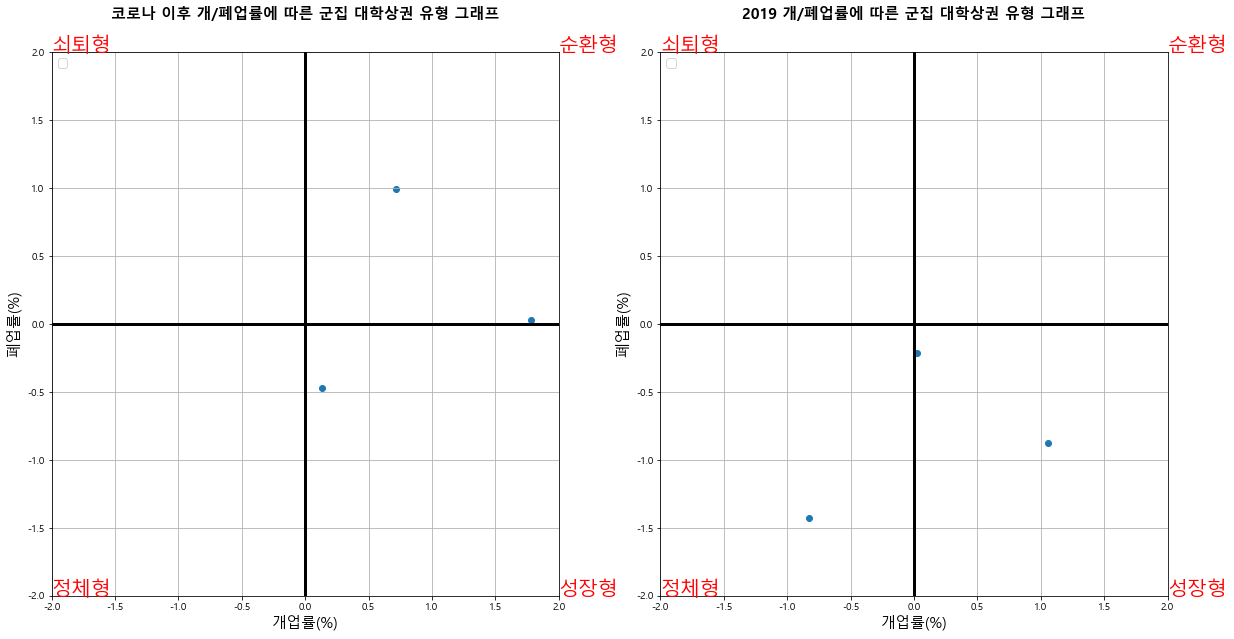

In [216]:
fig, ax = plt.subplots(1,2, figsize =(20,10))

ax[0].scatter(e["개업률(%)"], e["폐업률(%)"], cmap='coolwarm')
ax[1].scatter(e["2019_개업률(%)"], e["2019_폐업률(%)"], cmap='coolwarm')

for i, name in enumerate(['코로나 이후','2019']):
    ax[i].set_title("{} 개/폐업률에 따른 군집 대학상권 유형 그래프".format(name), fontdict= {'fontsize': 15, 'fontweight':'bold'} , 
                    y=1.05)
    ax[i].set_xlabel("개업률(%)", fontsize=15)
    ax[i].set_ylabel("폐업률(%)", fontsize=15)
    ax[i].grid()

    # X,Y 축 고정
    ax[i].set_xlim([-2,2])
    ax[i].set_ylim([-2,2])

    # x,y축 그리기
    ax[i].axvline(x = 0, color='black', linewidth=3, )
    ax[i].axhline(y = 0, color='black', linewidth=3)
    ax[i].legend(fontsize=12, loc='upper left')

    # 사분면 정의 된bb거 text 표시
    ax[i].text(2.0, 2.0, '순환형', fontsize=20, color='red')
    ax[i].text(2.0, -2.0, '성장형', fontsize=20, color='red') 
    ax[i].text(-2.0, -2.0, '정체형', fontsize=20, color='red') 
    ax[i].text(-2.0, 2.0, '쇠퇴형', fontsize=20, color='red') 

#### (3)번 군집

In [217]:
# 2019년 이전 각 상권별 개/폐율 
openstore_ratio_bycma_before_2019 = openstore_ratio_bycma.iloc[:, :12].mean(axis = 1).round(3)
closestore_ratio_bycma_before_2019 = closestore_ratio_bycma.iloc[:, :12].mean(axis = 1).round(3)

# 2019년 대학 상권 평균 개/폐율
open_point_before2019 = np.round(openstore_ratio_byquan[:12].mean(),3)
close_point_before2019 = np.round(closestore_ratio_byquan[:12].mean(),3)

open_before2019 = openstore_ratio_bycma_before_2019 - open_point_before2019
close_before2019 = closestore_ratio_bycma_before_2019 - close_point_before2019

value_before2019 = pd.DataFrame({'2019년_이전_개업률(%)' : open_before2019 , '2019년_이전_폐업률(%)' : close_before2019})

### segmentation 결과 합치기
value_before2019  = pd.merge(value_before2019 .reset_index(), cluster_result, on = '상권_코드_명', how ='inner')
value_before2019  = value_before2019 .set_index('상권_코드_명')

type_of_2019 = []

for i in range(value_before2019.shape[0]):
    if value_before2019.iloc[i, 0] >= 0 and value_before2019.iloc[i,1] >= 0:
        type_of_2019.append("순환형")

    elif value_before2019.iloc[i, 0] >= 0 and value_before2019.iloc[i,1] < 0:
        type_of_2019.append("성장형")

    elif value_before2019.iloc[i, 0] < 0 and value_before2019.iloc[i,1] >= 0:
        type_of_2019.append("쇠퇴형")

    else:
        type_of_2019.append("정체형")

value_before2019 ['2019년이전_골목상권_유형'] = type_of_2019

In [218]:
# 2019년 이후 각 상권별 개/폐율 
openstore_ratio_bycma_after_2019 = openstore_ratio_bycma.iloc[:, 16:].mean(axis = 1).round(3)
closestore_ratio_bycma_after_2019 = closestore_ratio_bycma.iloc[:, 16:].mean(axis = 1).round(3)

# 2019년 이후 대학 상권 평균 개/폐율
open_point_after2019 = np.round(openstore_ratio_byquan[12:].mean(),3)
close_point_after2019 = np.round(closestore_ratio_byquan[12:].mean(),3)

open_after2019 = openstore_ratio_bycma_after_2019 - open_point_after2019
close_after2019 = closestore_ratio_bycma_after_2019 - close_point_after2019

value_after2019 = pd.DataFrame({'2019년_이후_개업률(%)' : open_after2019 , '2019년_이후_폐업률(%)' : close_after2019})

### segmentation 결과 합치기
value_after2019  = pd.merge(value_after2019 .reset_index(), cluster_result, on = '상권_코드_명', how ='inner')
value_after2019  = value_after2019 .set_index('상권_코드_명')

type_of_2019 = []

for i in range(value_after2019.shape[0]):
    if value_after2019.iloc[i, 0] >= 0 and value_after2019.iloc[i,1] >= 0:
        type_of_2019.append("순환형")

    elif value_after2019.iloc[i, 0] >= 0 and value_after2019.iloc[i,1] < 0:
        type_of_2019.append("성장형")

    elif value_after2019.iloc[i, 0] < 0 and value_after2019.iloc[i,1] >= 0:
        type_of_2019.append("쇠퇴형")

    else:
        type_of_2019.append("정체형")

value_after2019 ['2019년이후_골목상권_유형'] = type_of_2019

In [219]:
re = pd.merge(value_before2019.reset_index(), value_after2019.reset_index(), on =['상권_코드_명','segment'])
r = re.copy()

In [220]:
re = re.query('segment == 1')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


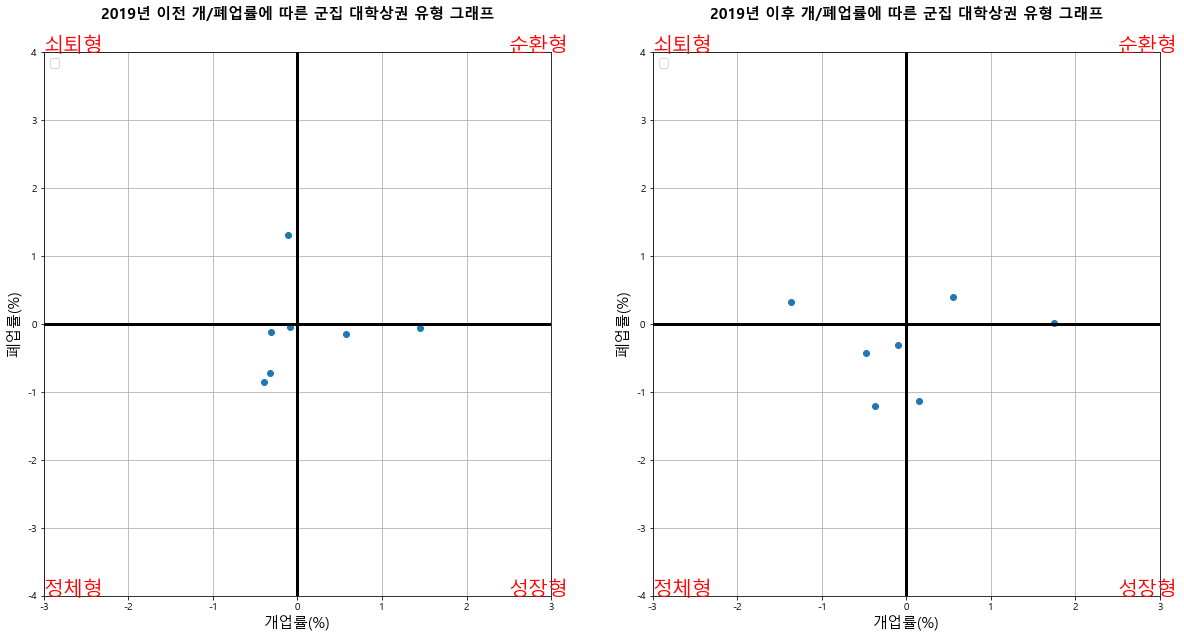

In [221]:
fig, ax = plt.subplots(1,2, figsize =(20,10))

ax[0].scatter(re["2019년_이전_개업률(%)"], re["2019년_이전_폐업률(%)"], cmap='coolwarm')
ax[1].scatter(re["2019년_이후_개업률(%)"], re["2019년_이후_폐업률(%)"], cmap='coolwarm')

for i, name in enumerate(['2019년 이전','2019년 이후']):
    ax[i].set_title("{} 개/폐업률에 따른 군집 대학상권 유형 그래프".format(name), fontdict= {'fontsize': 15, 'fontweight':'bold'} , 
                    y=1.05)
    ax[i].set_xlabel("개업률(%)", fontsize=15)
    ax[i].set_ylabel("폐업률(%)", fontsize=15)
    ax[i].grid()

    # X,Y 축 고정
    ax[i].set_xlim([-3,3])
    ax[i].set_ylim([-4,4])
    
    # x,y축 그리기
    ax[i].axvline(x = 0, color='black', linewidth=3, )
    ax[i].axhline(y = 0, color='black', linewidth=3)
    ax[i].legend(fontsize=12, loc='upper left')

    # 사분면 정의 된bb거 text 표시
    ax[i].text(2.5, 4.0, '순환형', fontsize=20, color='red')
    ax[i].text(2.5, -4.0, '성장형', fontsize=20, color='red') 
    ax[i].text(-3.0, -4.0, '정체형', fontsize=20, color='red') 
    ax[i].text(-3.0, 4.0, '쇠퇴형', fontsize=20, color='red')

In [222]:
find_list = ['신촌로12길','서울 광진구 건대입구역_1','서울 마포구 홍대입구역_1','서울 광진구 군자역','서울 성북구 성신여대입구역',
 '서울 종로구 경복궁역_2','서울 종로구 경복궁역_1','고속터미널역','서초중앙로8길','서울시립대로29길','서울 성북구 안암역']

In [223]:
qeqe = re.query('상권_코드_명 in @find_list')
qeqe = qeqe.reset_index(drop = True)
qeqe =qeqe.set_index('상권_코드_명')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


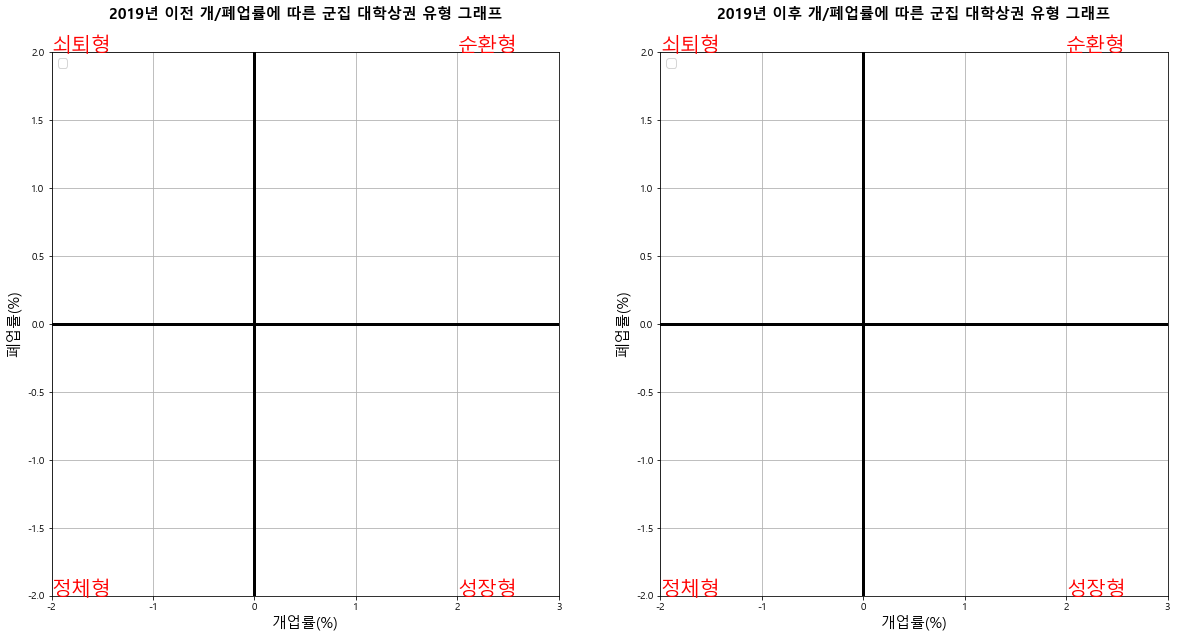

In [224]:
fig, ax = plt.subplots(1,2, figsize =(20,10))

ax[0].scatter(qeqe["2019년_이전_개업률(%)"], qeqe["2019년_이전_폐업률(%)"], cmap='coolwarm')

for n in range(qeqe.shape[0]):
    ax[0].text(qeqe['2019년_이전_개업률(%)'][n]*1.02, qeqe['2019년_이전_폐업률(%)'][n]*0.98, 
             qeqe.index[n], fontsize=13)

ax[1].scatter(qeqe["2019년_이후_개업률(%)"], qeqe["2019년_이후_폐업률(%)"], cmap='coolwarm')

for n in range(qeqe.shape[0]):
    ax[1].text(qeqe['2019년_이후_개업률(%)'][n]*1.01, qeqe['2019년_이후_폐업률(%)'][n]*0.99, 
               qeqe.index[n], fontsize=13)


for i, name in enumerate(['2019년 이전','2019년 이후']):
    ax[i].set_title("{} 개/폐업률에 따른 군집 대학상권 유형 그래프".format(name), fontdict= {'fontsize': 15, 'fontweight':'bold'} , 
                    y=1.05)
    ax[i].set_xlabel("개업률(%)", fontsize=15)
    ax[i].set_ylabel("폐업률(%)", fontsize=15)
    ax[i].grid()

    # X,Y 축 고정
    ax[i].set_xlim([-2,3])
    ax[i].set_ylim([-2,2])
    
    # x,y축 그리기
    ax[i].axvline(x = 0, color='black', linewidth=3, )
    ax[i].axhline(y = 0, color='black', linewidth=3)
    ax[i].legend(fontsize=12, loc='upper left')

    # 사분면 정의 된bb거 text 표시
    ax[i].text(2.0, 2.0, '순환형', fontsize=20, color='red')
    ax[i].text(2.0, -2.0, '성장형', fontsize=20, color='red') 
    ax[i].text(-2.0, -2.0, '정체형', fontsize=20, color='red') 
    ax[i].text(-2.0, 2.0, '쇠퇴형', fontsize=20, color='red')

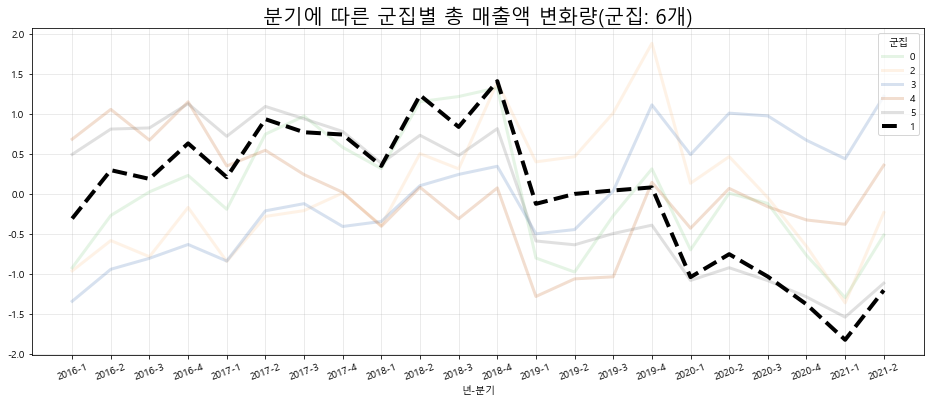

In [165]:
temp_final = temp_0.copy()

# cluster
kmeans = KMeans(n_clusters=6, random_state=0).fit(temp_final)
temp_final['segment'] = kmeans.labels_

ax=temp_final.query('segment != 1').groupby('segment').mean().T.plot(figsize=(16, 6), 
                                                                  cmap=plt.cm.Accent, linewidth=3, style='-', alpha=0.2)
ax=temp_final.query('segment == 1').groupby('segment').mean().T.plot(ax=ax, color='black', linewidth=4, style='--', alpha=1)
plt.xticks([i for i in range(len(temp_final.columns)-1)], temp_final.columns[:-1], rotation=20)

plt.legend(loc='upper right', title='군집')
plt.grid(alpha=0.3)
plt.title('분기에 따른 군집별 총 매출액 변화량(군집: 6개)', size=20)
plt.show()

In [172]:
temp_final.query('segment== 1').index

Index(['개봉로17다길', '개봉로2길', '개운사길', '경인로47길', '경희대로4길', '고산자로6길', '고속터미널역',
       '광나루로12길', '광나루로24길', '광나루로36길', '광성로6길', '남부순환로325길', '능동로19길',
       '대흥로21길', '돌곶이로22길', '동소문로26가길', '동소문로6길', '동일로192길', '마조로1길', '만리재옛길',
       '망우로18가길', '망우로18길', '명동길', '보문로32길', '부일로1길', '사가정로13길', '사임당로17길',
       '사평대로26길', '삼선교로10다길', '삼양로144길', '삼일대로4길', '상도로61길', '상도로62길', '상원12길',
       '서교시장', '서대문구 서대문역_2', '서울 광진구 건대입구역_1', '서울 광진구 군자역', '서울 동대문구 청량리역',
       '서울 마포구 홍대입구역_1', '서울 성북구 성신여대입구역', '서울 성북구 안암역', '서울 종로구 경복궁역_1',
       '서울 종로구 경복궁역_2', '서울 종로구 광화문역_2', '서울 중구 충무로역_1', '서울시립대로29길',
       '서초중앙로8길', '석계로1길', '석관시장', '성안로3길', '신촌로12길', '신촌역', '연서로5길', '오류동역',
       '오류로8길', '오패산로4길', '와우산로3길', '용마산로94길', '원효로89길', '잠실 관광특구', '장월로1길',
       '장충동 족발거리', '장한평역', '전농로터리시장', '정릉로8길', '정릉시장', '제기로21길', '중앙로1길',
       '증가로10길', '천장산로7길', '청파로47길', '통일로11길', '퇴계로12길', '퇴계로8길', '필운대로1길',
       '한아름시장', '한양시장', '화곡로44나길', '화곡로64길', '화랑로13길', '화랑로19길', '회기시장',
       '휘경로23길', '